In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

In [105]:
def get_confusion_matrix(cm, labels):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [106]:
df = pd.read_csv("./output/fights_cleaned.csv", delimiter=";")
df.shape

(4878, 158)

In [120]:
print(df["WINNER"].value_counts())
print(df.loc[:4000,"WINNER"].value_counts())
print(df.loc[4000:,"WINNER"].value_counts())

red     3009
blue    1787
Name: WINNER, dtype: int64
red     2256
blue    1672
Name: WINNER, dtype: int64
red     754
blue    115
Name: WINNER, dtype: int64


In [108]:
# due to rarity of draws it will not be considered, so we have a binary classification problem
df = df[df["WINNER"]!="draw/NC"]

- Apparently, in the early fights of the UFC, the red-blue concept was not yet introduced, so the website probably assigned the winner to the red color.
- This should be taken into account as it changes the base prediction
- possible solutions could be oversampling of the "blue-Winner"-population

### get training & test set
- data is not normalized

In [109]:
y = df['WINNER']
X = df.drop(columns = ['WINNER','FIGHTER_R','FIGHTER_B'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)

In [110]:
clf_1  = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1)

In [111]:
clf_1.fit(X_train, y_train)
y_pred = clf_1.predict(X_test)

clf_1.oob_score_

0.6812993854258121

In [112]:
print("RandomForrest accuracy: ", accuracy_score(y_test, y_pred))
print("Baseline accuracy: ", accuracy_score(y_test, ["red"]*len(y_test)))

RandomForrest accuracy:  0.7458333333333333
Baseline accuracy:  0.6625


In [113]:
feature_scores = pd.Series(clf_1.feature_importances_, index=X_train.columns).sort_values(ascending=False)
with pd.option_context('display.max_rows', 1000, 'display.max_columns', None):
    display(feature_scores)

LOSS_PRE_UFC_B         0.022985
WIN_PRE_UFC_R          0.022775
DRAW_PRE_UFC_R         0.020792
DRAW_PRE_UFC_B         0.015159
LOSS_PRE_UFC_R         0.014105
AGE_R                  0.013873
STR_HEAD_OPP_R         0.012575
WIN_PRE_UFC_B          0.012013
STR_BODY_ATT_B         0.011163
AGE_B                  0.010785
SIG_STR_OPP_R          0.010660
DISTANCE_OPP_R         0.010636
TOTAL_STR_OPP_R        0.010317
DISTANCE_B             0.010247
GROUND_ATT_R           0.010030
CTRL_R                 0.009983
GROUND_R               0.009881
TOTAL_STR_OPP_B        0.009785
DISTANCE_ATT_B         0.009758
TOTAL_STR_R            0.009564
STR_BODY_OPP_R         0.009378
CTRL_OPP_B             0.009350
GROUND_ATT_OPP_B       0.009349
STR_HEAD_OPP_B         0.009345
STR_HEAD_B             0.009283
STR_BODY_ATT_OPP_R     0.009236
STR_BODY_R             0.009109
CTRL_OPP_R             0.009106
TOTAL_STR_ATT_R        0.008945
SIG_STR_ATT_B          0.008911
STR_BODY_ATT_R         0.008882
STR_BODY

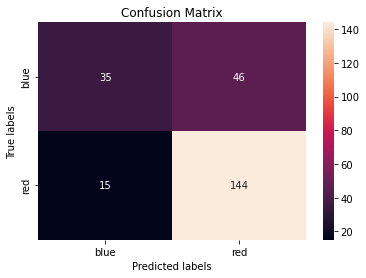

In [114]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
labels = unique_labels(y_test, y_pred)

get_confusion_matrix(conf_matrix,labels)

### comparing Oversampling, Undersampling and manual Data Selection

In [115]:
# Oversampling
ros = RandomOverSampler(random_state=1)
X_train_ov, y_train_ov = ros.fit_resample(X_train, y_train)

# Undesampling
rus = RandomUnderSampler(random_state=1)
X_train_und, y_train_und = rus.fit_resample(X_train, y_train)

# Manual Data selection of (newer) events with blue and red corner concept
df_new = df[:-622]
y_new = df_new['WINNER']
X_new = df_new.drop(columns = ['WINNER','FIGHTER_R','FIGHTER_B'])
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.05, random_state=1)

In [116]:
# fitting models
clf_2 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1)
clf_3 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1)
clf_4 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1)

clf_2.fit(X_train_ov, y_train_ov)
clf_3.fit(X_train_und, y_train_und)
clf_4.fit(X_train_new, y_train_new)

y_pred_ov = clf_2.predict(X_test)
y_pred_und = clf_3.predict(X_test)
y_pred_new = clf_4.predict(X_test_new)

In [117]:
# Evaluate perfomance
print("Oversampling RandomForrest accuracy: ", accuracy_score(y_test, y_pred_ov))
print("Oversampling Baseline accuracy: ", accuracy_score(y_test, ["red"]*len(y_test)))

print("Undesampling RandomForrest accuracy: ", accuracy_score(y_test, y_pred_und))
print("Undesampling Baseline accuracy: ", accuracy_score(y_test, ["red"]*len(y_test)))

print("Manual selection RandomForrest accuracy: ", accuracy_score(y_test_new, y_pred_new))
print("Manual selection Baseline accuracy: ", accuracy_score(y_test_new, ["red"]*len(y_test_new)))

Oversampling RandomForrest accuracy:  0.7291666666666666
Oversampling Baseline accuracy:  0.6625
Undesampling RandomForrest accuracy:  0.6458333333333334
Undesampling Baseline accuracy:  0.6625
Manual selection RandomForrest accuracy:  0.645933014354067
Manual selection Baseline accuracy:  0.49760765550239233


- the test-accuracies of the RFs combined with sampling methods are still worse than the model without any
- when using Undersampling the accuracy is even lower than the accuracy of a trivial classifier

### Tuning of Hyperparameters

In [121]:
parameters = {
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500, 1000, None],
            'max_features': ['sqrt','auto', None]
            }

In [122]:
clf_5 = RandomForestClassifier(random_state=1, n_estimators=1000, criterion='gini')
rf_cv = GridSearchCV(estimator = clf_5, param_grid = parameters, cv=4, n_jobs = -1, verbose=1 #,n_iter=10
                        )
rf_cv.fit(X_train, y_train)

Fitting 4 folds for each of 39 candidates, totalling 156 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=1000,
                                              random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       500, 1000, None],
                         'max_features': ['sqrt', 'auto', None]},
             verbose=1)

In [123]:
rf_cv.best_params_

{'max_depth': 30, 'max_features': None}

In [124]:
with open("./output/random_forest_params", "w") as f:
    json.dump(rf_cv.best_params_, f, indent=4)

In [126]:
clf_6 = rf_cv.best_estimator_

In [128]:
y_6_preds = clf_6.predict(X_test)
accuracy_score(y_test, y_6_preds)

0.7458333333333333

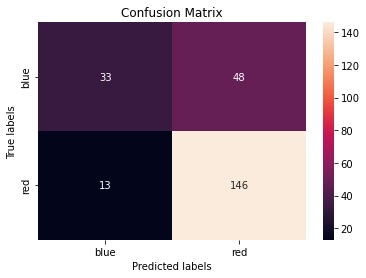

In [129]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_6_preds)
labels = unique_labels(y_test, y_6_preds)

get_confusion_matrix(conf_matrix,labels)

In [130]:
print(classification_report(y_test, y_6_preds))

              precision    recall  f1-score   support

        blue       0.72      0.41      0.52        81
         red       0.75      0.92      0.83       159

    accuracy                           0.75       240
   macro avg       0.73      0.66      0.67       240
weighted avg       0.74      0.75      0.72       240



- no improvement by hyperparameter tuning